# Import

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import geopandas as gpd

from pathlib import Path
import sys
import os
import glob
import multiprocessing as mp
from datetime import date


pd.options.mode.chained_assignment = None  # default='warn'

# Data

In [13]:
%%time
# Folders
repository = Path.cwd()
dataFolder = repository.parent.parent / 'InOutRepoData' / 'FFE'
folder = dataFolder / 'ProbaScenarioOutput'

Wall time: 0 ns


In [18]:
%%time
# Data

wind_data = pd.read_csv(repository / 'data' / 'Copy_of_GD_wind.csv')
building_data = gpd.read_file(repository / 'data' / 'shapefile' / 'BuildingFootprints.shp')
building_data = dd.from_pandas(building_data.drop(columns=['geometry']), npartitions=1)
edgelist = pd.read_parquet(repository / 'data' / 'Copy_of_edge_data.parquet', engine='pyarrow')
edgelist.drop(columns=['IgnProb_bl'], inplace=True)
earthquake_events = dd.read_parquet(dataFolder / 'ProbaScenariosInput' / 'joinSA_PGA.parquet', engine='pyarrow')
earthquake_events = earthquake_events.drop(columns=['__null_das'])

Wall time: 6.68 s


In [30]:
EQs = earthquake_events
buildings = building_data
EQ = EQs[EQs['event_id']==EventNumber]
print(EQ)
buildingEQ = buildings.merge(EQ, on=['SA2_ID'], how='left')
print(buildingEQ)

Dask DataFrame Structure:
              event_id site_id SA2_ID  gmv_PGA      lon      lat  IgnProb
npartitions=1                                                            
                 int64   int64  int64  float64  float64  float64  float64
                   ...     ...    ...      ...      ...      ...      ...
Dask Name: getitem, 5 tasks
Dask DataFrame Structure:
              OBJECTID Replacemen Combustibl FloorArea BLDG_ID Shape_Leng Shape_Area SA2_ID NightOccup event_id site_id  gmv_PGA      lon      lat  IgnProb
npartitions=1                                                                                                                                              
               float64    float64      int64   float64   int64    float64    float64  int64    float64    int64   int64  float64  float64  float64  float64
                   ...        ...        ...       ...     ...        ...        ...    ...        ...      ...     ...      ...      ...      ...      ...


In [35]:
Geo = gpd.GeoDataFrame(buildingEQ.compute(), geometry=gpd.points_from_xy(buildingEQ.compute().lon, buildingEQ.compute().lat))

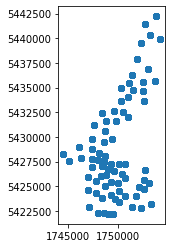

In [37]:
Geo.plot()

### **Method : PGA_SA join --> pick 1 EQ event --> Attach Ignition Probability to buildings --> Run Fire scenario**

## Parallel computing set up

In [5]:
import ipyparallel as ipp
client = ipp.Client()
dview = client[:]# limit to 10 cores for now
client.ids

<DirectView [0, 1, 2, 3,...]>

In [6]:
len(dview)

10

In [9]:
# add variables to all engines
dview["edgelist"]=edgelist
dview["buildings"]=building_data
dview["wind_data"]=wind_data
dview["folder"]=folder
dview["earthquake_events"]=earthquake_events


# add all libraries to engines
with dview.sync_imports():
    import numpy as np
    import pandas as pd
    import dask.dataframe as dd
    import geopandas as gpd
    from pathlib import Path
    import sys
    import os
    import glob
    from datetime import date

importing numpy on engine(s)
importing pandas on engine(s)
importing Path from pathlib on engine(s)
importing sys on engine(s)
importing os on engine(s)
importing glob on engine(s)
importing date from datetime on engine(s)


## Functions

In [10]:
# %%px

def wind_scenario(wind_data):
    import numpy as np
    i = np.random.randint(0, wind_data.values.shape[0])
    w = wind_data.values[i, 2]
    dist = wind_data.values[i, 1]
    b = wind_data.values[i, 3]
    bear_max = b + 45  # wind direction
    bear_min = b - 45
    if b == 360:
        bear_max = 45
    if b <= 0:  # should not be necessary
        bear_min = 0
    if b == 999:
        bear_max = 999
        bear_min = 0
    return bear_max, bear_min, dist # wind characteristics, bearing and distance


def earthquake_scenario(EQs=earthquake_events, buildings=building_data):
    import numpy as np
    import pandas as pd
    import dask.dataframe as dd

    EventNumber = np.random.randint(0,max(EQs['event_id'])) # use range of OpenQuake events
    EQ = EQs[EQs['event_id']==EventNumber]
    buildingEQ = buildings.merge(EQ, on=['SA2_ID'], how='left')
    return buildingEQ[['source','gmv_PGA','IgnProb']] # former RNGfile


def ignition(rngFile, edges=edgelist):
    import numpy as np
    import pandas as pd
    
    rngList = rngFile[['source', 'IgnProb']]
    rngList = rngList.drop_duplicates(columns=['source']).compute()

    rngList['rng'] = np.random.uniform(0, 1, size=rngList.values.shape[0])
    rngList = rngList[rngList['rng'] < rngList['IgnProb']]
    initialIgnitions = len(rngList)
    NewActiveEdges = edges[edges['source'].isin(rngList['source'])]
    return NewActiveEdges, initialIgnitions


def mask(t, activeEdges_d, listActivatedSources_d, w_b_max, w_b_min, w_d):
    import numpy as np
    if t==0: # special case at time=0
        return activeEdges_d
    else:
        mask = (activeEdges_d.bearing.values < w_b_max) & (activeEdges_d.bearing.values < w_b_min) & (activeEdges_d.distance < w_d)
        NewActiveEdges = activeEdges_d[mask]
        NewActiveEdges = NewActiveEdges[~NewActiveEdges.source.isin(listActivatedSources_d)]
        return NewActiveEdges


def propagation(activeEdges_d, edges=edgelist):
    import numpy as np
    import pandas as pd
    NewActiveEdges = edges[edges.source.isin(activeEdges_d.target)]
    return NewActiveEdges


In [11]:
@dview.parallel(block = False) # The @parallel decorator breaks up elementwise operations and distributes them.
def EQffe_runs(n):
    import numpy as np
    import pandas as pd
    from datetime import date
    for EQFFEscenario in n:
        EQscenario = earthquake_scenario()
        # initial setup
        listActivatedSources = []
        listScenarioDataframes = []
        condition = True
        time = 0 
        # wind conditions
        w_bearing_max, w_bearing_min, w_distance = wind_scenario(wind_data)
        # ignition / initial state and edges selection
        ActiveEdges, numberIgnitions = ignition(EQscenario)
        if ActiveEdges.empty:
            print(f"no ignitions {numberIgnitions}")
            condition = False
            continue
        while condition: # spread burn zone
            ActiveEdges = mask(time, ActiveEdges, listActivatedSources, w_bearing_max, w_bearing_min, w_distance)
            if ActiveEdges.empty: #no more buildings to burn
                break
            burns = ActiveEdges.drop_duplicates(['source'], inplace=False)
#             print(f"Active edges {len(ActiveEdges)} / no duplicate = {len(burns)}")
            burns['time'] = time
            listScenarioDataframes.append(burns)
            listActivatedSources.extend(ActiveEdges.source.values)
            ActiveEdges = propagation(ActiveEdges)
            time += 1
        
        print(f'finishing scenario --- {EQFFEscenario} time ---- {time} \n started with {numberIgnitions} ignitions ')

        Activations = pd.concat(listScenarioDataframes)
        Activations["EQFFEscenario"] = EQFFEscenario
        Activations["InitialIgnitions"] = numberIgnitions
        Activations.to_parquet(str(folder) + '/' + f'scenario{EQFFEscenario}_{str(date.today())}.parquet', engine='auto', compression="GZIP")
        # save parameters behind the scenario
        parameters = {'building_id':EQscenario['source'].values,
                      'gmf_PGA':EQscenario['gmf_PGA'].values,
                      'IgnProb':EQscenario['IgnProb'].values,
                      'Wind bearing max': np.repeat(w_bearing_max.values, len(EQscenario)),
                      'Wind bearing min': np.repeat(w_bearing_min.values, len(EQscenario)),
                     'Wind distance': np.repeat(w_distance.values, len(EQscenario)}
        df_parameters = pd.Dataframe(parameters, columns=['building_id','gmf_PGA',
                                                          'IgnProb','Wind bearing max',
                                                          'Wind bearing min','Wind distance'])
        df_parameters.to_csv(str(folder) + '/' + f'parameters{EQFFEscenario}_{str(date.today())}.csv)    

# Run

In [12]:
%%time
EQffe_runs(range(10))

Wall time: 6 ms


<AsyncMapResult: ffe_runs>


### Backup and testing

In [16]:
test = pd.read_parquet(folder / 'scenario0_2020-08-06.parquet')
test

source  target   distance     bearing  IgnProbBld  time  scenario  \
58927      1339    7165  85.191863  254.643103    0.000073     0         0   
177754     4087    1171  42.839607  146.200091    0.000068     0         0   
1553230   36012   20709  46.135131  327.995628    0.005239     0         0   
1838643   42567     819  61.723592  176.924230    0.000288     0         0   
1870466   43322      69  18.925020  224.543699    0.000253     0         0   
2437404   56553    2724  79.663636  261.571453    0.000117     0         0   
2500477   58033      38  73.423960   28.218908    0.000313     0         0   
3072849   71356     513  65.566426  303.012553    0.000213     0         0   

         InitialIgnitions  
58927                   8  
177754                  8  
1553230                 8  
1838643                 8  
1870466                 8  
2437404                 8  
2500477                 8  
3072849                 8

In [14]:
# def clean_up(path=folder):
#     files = path.glob('*scenario*')
#     for f in files:
#         print(f)
#         os.remove(f)

In [15]:
# clean_up()